# Model Agnostic Meta Learning (MAML)

Notebook for the Medium post. Based on the paper

https://arxiv.org/abs/1703.03400

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

import time
from collections import OrderedDict

from utils import (
    LossMetric, 
    print_bar,
)

from data import (
    Dataset,
    SinusoidGenerator,
)

from meta import (
    LossImportance, 
    parse_attr_name,
    set_model_attrs,
    meta_forward,
    meta_adapt,
)

### Hyperparameters

In [2]:
batch_size = 32
num_epochs = 50
inner_train_steps = 5     # number of train steps for inner loop
init_lr = 1e-2            # initial learning rate for learnable lr's.
inner_lr = 1e-2           # lr during train step
outer_lr = 1e-2           # lr during meta step
use_trainable_lrs = True  # self explanatory
use_second_order = True   # use second order derivatives

### Model creation

We're fitting sine functions (on a fixed interval), so a simple 3 layer feed forward net is good enough to do the job.

In [3]:
loss_fn = nn.MSELoss()

loader = torch.utils.data.DataLoader(Dataset(), batch_size)

model = nn.Sequential(
    nn.Linear(1, 40), 
    nn.ReLU(), 
    nn.Linear(40, 40), 
    nn.ReLU(), 
    nn.Linear(40, 1)
)

trainable_lrs = OrderedDict({
    key.replace('.','-'): nn.Parameter(
        data=torch.ones(inner_train_steps, requires_grad=use_trainable_lrs) * init_lr,
        requires_grad=True
    )
    for key, param in model.named_parameters()
})

optimizer_lr = torch.optim.Adam(trainable_lrs.values(), lr=inner_lr)
optimizer = torch.optim.Adam(model.parameters(), lr=outer_lr)

### Train

In [5]:
ds_size = len(loader)
loss_metric = LossMetric()
loss_importance = LossImportance(K=inner_train_steps, train_steps=ds_size * num_epochs)
history = {'loss':[]}

start = time.time()
GLOB_STEP = 0

for epoch in range(1, num_epochs+1):
    for step, (x_batch, y_batch) in enumerate(loader):
        
        losses = []
        
        optimizer.zero_grad()
        optimizer_lr.zero_grad()
        
        for i in range(x_batch.shape[0]):
            x = x_batch[i].reshape(-1, 1)
            y = y_batch[i].reshape(-1, 1)
            
            loss, param_dict = meta_forward(
                model=model, 
                x=x, 
                y=y,
                loss_fn=loss_fn,
                loss_importance=loss_importance(GLOB_STEP),
                trainable_lrs=trainable_lrs,
                K=inner_train_steps,
                create_graph=use_second_order
            )
            
            losses.append(loss)
            
        loss = torch.mean(torch.stack(losses))
        loss_metric.update(loss)
        
        GLOB_STEP += 1
        print_bar(step, GLOB_STEP, ds_size, loss_metric, start, num_epochs, epoch)
        history['loss'].append(loss_metric.value())
        
        loss.backward()
        
        optimizer.step()
        optimizer_lr.step()

Epoch: 1. Iter: 16/800  [====================>]  Loss: 12.6451. Time: 5.7 iter/s, 138 remaining.
Epoch: 2. Iter: 32/800  [====================>]  Loss: 9.5140. Time: 5.7 iter/s, 135 remaining..
Epoch: 3. Iter: 48/800  [====================>]  Loss: 7.8628. Time: 5.7 iter/s, 132 remaining.
Epoch: 4. Iter: 64/800  [====================>]  Loss: 6.7191. Time: 5.7 iter/s, 130 remaining.
Epoch: 5. Iter: 80/800  [====================>]  Loss: 5.8362. Time: 5.7 iter/s, 127 remaining.
Epoch: 6. Iter: 96/800  [====================>]  Loss: 5.1402. Time: 5.6 iter/s, 125 remaining.
Epoch: 7. Iter: 112/800  [====================>]  Loss: 4.5728. Time: 5.6 iter/s, 124 remaining.
Epoch: 8. Iter: 128/800  [====================>]  Loss: 4.1013. Time: 5.6 iter/s, 121 remaining.
Epoch: 9. Iter: 144/800  [====================>]  Loss: 3.7331. Time: 5.6 iter/s, 118 remaining.
Epoch: 10. Iter: 160/800  [====================>]  Loss: 3.4245. Time: 5.5 iter/s, 116 remaining.
Epoch: 11. Iter: 176/800  [======

## Evaluate

We create a new task from the distribution using the same SinusoidGenerator() function as we did during training.

This is unseen, so we now train inner_train_steps on the generated data, then test on some test data generated from the same distribution. We show the result for the first K train steps.

In practice, we would just use our meta_adapt function, but here we want all of the intermediate results so we can plot progress!

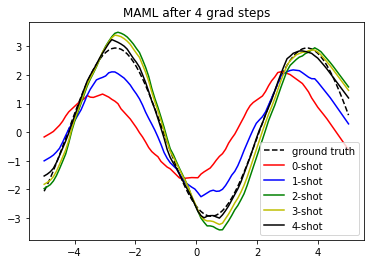

In [11]:
from copy import deepcopy
import matplotlib.pyplot as plt
import itertools as it

# Make new data by pulling a task from the same distribution
sg = SinusoidGenerator()
x = np.linspace(-5.0, 5.0, 100)

# Let's not mess with our train model, so we copy it.
model_copy = deepcopy(model)
param_dict = OrderedDict(model_copy.named_parameters())

# This will show the base model, before it's adapted
plt.plot(x, sg(x), 'k--', label='ground truth')

x_tens = torch.tensor(x, requires_grad=False).reshape(-1,1).float()
y_tens = torch.tensor(sg(x), requires_grad=False).reshape(-1,1).float()

# cycle through colors, quick way to do so
color = it.cycle(['r','b','g','y','k'])

for i in range(inner_train_steps):
    name = f"{i}-shot"
    yhat = model_copy(x_tens)
    pred = np.squeeze(yhat.detach().numpy())
    loss = loss_fn(yhat, y_tens)
    
    plt.plot(x, pred, c=next(color), label=name)
    
    grads = torch.autograd.grad(loss, param_dict.values(), create_graph=False)
    
    for (name, param), grad in zip(param_dict.items(), grads):
        lr = F.relu(trainable_lrs[name.replace('.','-')][i])
        param_dict[name] = param - lr * grad
        
    set_model_attrs(model_copy, param_dict)

plt.legend()
plt.title('MAML after 4 grad steps')
plt.show()